In [1]:
using Downloads, DataFrames, CSV, Chain, Dates

url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
file = Downloads.download(url)
df = CSV.File(file) |> DataFrame
br = @chain df begin
    filter([:date, :city] => (date, city) -> date < Dates.Date("2021-01-01") && date > Dates.Date("2020-04-01") && ismissing(city), _)
    groupby(:date)
    combine(
        [:estimated_population_2019,
            :last_available_confirmed_per_100k_inhabitants,
            :last_available_deaths,
            :new_confirmed,
            :new_deaths] .=> sum .=>
            [:estimated_population_2019,
                :last_available_confirmed_per_100k_inhabitants,
                :last_available_deaths,
                :new_confirmed,
                :new_deaths]
    )
end;

In [2]:
df

Row,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
,String?,Int64?,Date,Int64,Int64?,Int64?,Bool,Bool,Int64,Float64?,Date,Float64,Int64,Int64,String7,String3,Int64,Int64
1,Rio Branco,1200401,2020-03-17,202012,413418,407319,false,false,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0
2,missing,12,2020-03-17,202012,894470,881935,false,false,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0
3,Rio Branco,1200401,2020-03-18,202012,413418,407319,false,false,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0
4,missing,12,2020-03-18,202012,894470,881935,false,false,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0
5,Rio Branco,1200401,2020-03-19,202012,413418,407319,false,false,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0
6,missing,12,2020-03-19,202012,894470,881935,false,false,4,0.44719,2020-03-19,0.0,0,3,state,AC,1,0
7,Rio Branco,1200401,2020-03-20,202012,413418,407319,false,false,7,1.6932,2020-03-20,0.0,0,4,city,AC,3,0
8,missing,12,2020-03-20,202012,894470,881935,false,false,7,0.78259,2020-03-20,0.0,0,4,state,AC,3,0
9,Rio Branco,1200401,2020-03-21,202012,413418,407319,false,false,11,2.66075,2020-03-21,0.0,0,5,city,AC,4,0


In [3]:
first(br, 5)

Row,date,estimated_population_2019,last_available_confirmed_per_100k_inhabitants,last_available_deaths,new_confirmed,new_deaths
,Date,Int64,Float64,Int64,Int64,Int64
1,2020-04-02,210147125,79.6116,305,1167,61
2,2020-04-03,210147125,90.9596,365,1114,60
3,2020-04-04,210147125,103.622,445,1169,80
4,2020-04-05,210147125,115.594,496,1040,51
5,2020-04-06,210147125,125.766,569,840,73


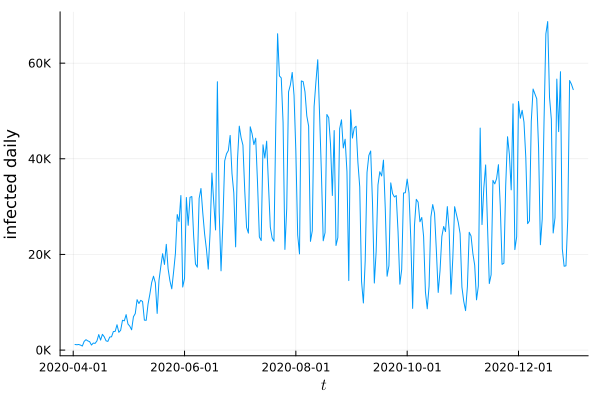

In [4]:
using Plots, StatsPlots, LaTeXStrings
@df br plot(:date,
    :new_confirmed,
    xlab=L"t", ylab="infected daily",
    yformatter=y -> string(round(Int64, y ÷ 1_000)) * "K",
    label=false)

In [5]:
using DifferentialEquations

function sir_ode!(du, u, p, t)
    (S, I, R) = u
    (β, γ) = p
    N = S + I + R
    infection = β * I * S / N
    recovery = γ * I
    @inbounds begin
        du[1] = -infection # Susceptible
        du[2] = infection - recovery # Infected
        du[3] = recovery # Recovered
    end
    nothing
end;

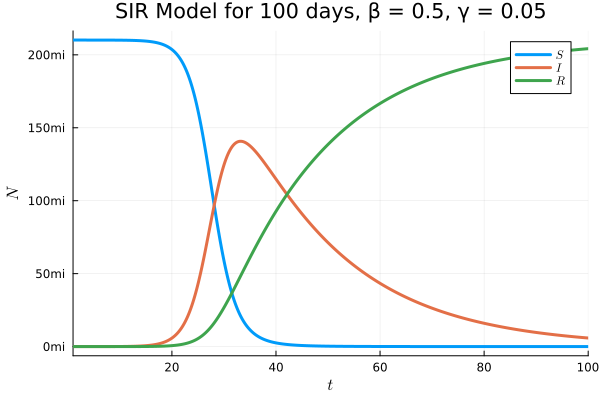

In [6]:
i₀ = first(br[:, :new_confirmed])
N = maximum(br[:, :estimated_population_2019])

u = [N - i₀, i₀, 0.0]
p = [0.5, 0.05]
prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
sol_ode = solve(prob)
plot(sol_ode, label=[L"S" L"I" L"R"],
    lw=3,
    xlabel=L"t",
    ylabel=L"N",
    yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
    title="SIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

In [7]:
function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

NegativeBinomial2 (generic function with 1 method)

In [8]:
using Turing
using LazyArrays
using Random: seed!
seed!(123)

@model function bayes_sir(infected, i₀, r₀, N)
    #calculate number of timepoints
    l = length(infected)

    #priors
    β ~ TruncatedNormal(2, 1, 1e-4, 10)     # using 10 because numerical issues arose
    γ ~ TruncatedNormal(0.4, 0.5, 1e-4, 10) # using 10 because numerical issues arose
    ϕ⁻ ~ truncated(Exponential(5); lower=0, upper=1e5)
    ϕ = 1.0 / ϕ⁻

    #ODE Stuff
    I = i₀
    u0 = [N - I, I, r₀] # S,I,R
    p = [β, γ]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_ode!,
        u0,
        tspan,
        p)
    sol = solve(prob,
        Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
        saveat=1.0)
    solᵢ = Array(sol)[2, :] # New Infected
    solᵢ = max.(1e-4, solᵢ) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(solᵢ, ϕ)))
end;

In [9]:
infected = br[:, :new_confirmed]
r₀ = first(br[:, :new_deaths])
model_sir = bayes_sir(infected, i₀, r₀, N)
chain_sir = sample(model_sir, NUTS(), 1_000)
summarystats(chain_sir[[:β, :γ]])

Sampling   0%|█                                         |  ETA: N/A
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference C:\Users\ajaoo\.julia\packages\Turing\dl9my\src\inference\hmc.jl:191


Sampling   0%|█                                         |  ETA: 1:20:22
Sampling   1%|█                                         |  ETA: 0:40:05
Sampling   1%|█                                         |  ETA: 0:26:36
Sampling   2%|█                                         |  ETA: 0:19:52
Sampling   2%|█                                         |  ETA: 0:15:50
Sampling   3%|██                                        |  ETA: 0:13:08


Sampling   3%|██                                        |  ETA: 0:11:13
Sampling   4%|██                                        |  ETA: 0:09:47
Sampling   4%|██                                        |  ETA: 0:08:39
Sampling   5%|██                                        |  ETA: 0:07:45
Sampling   5%|███                                       |  ETA: 0:07:01
Sampling   6%|███                                       |  ETA: 0:06:25


Sampling   6%|███                                       |  ETA: 0:05:53
Sampling   7%|███                                       |  ETA: 0:05:27
Sampling   7%|███                                       |  ETA: 0:05:04
Sampling   7%|████                                      |  ETA: 0:04:44
Sampling   8%|████                                      |  ETA: 0:04:26


Sampling   8%|████                                      |  ETA: 0:04:11
Sampling   9%|████                                      |  ETA: 0:03:57


Sampling   9%|████                                      |  ETA: 0:03:44
Sampling  10%|█████                                     |  ETA: 0:03:33


Sampling  10%|█████                                     |  ETA: 0:03:24
Sampling  11%|█████                                     |  ETA: 0:03:15


Sampling  11%|█████                                     |  ETA: 0:03:07
Sampling  12%|█████                                     |  ETA: 0:02:59


Sampling  12%|██████                                    |  ETA: 0:02:52
Sampling  13%|██████                                    |  ETA: 0:02:45
Sampling  13%|██████                                    |  ETA: 0:02:39


Sampling  14%|██████                                    |  ETA: 0:02:33


Sampling  14%|██████                                    |  ETA: 0:02:27
Sampling  14%|███████                                   |  ETA: 0:02:22


Sampling  15%|███████                                   |  ETA: 0:02:17


Sampling  15%|███████                                   |  ETA: 0:02:14
Sampling  16%|███████                                   |  ETA: 0:02:10
Sampling  16%|███████                                   |  ETA: 0:02:05
Sampling  17%|████████                                  |  ETA: 0:02:01
Sampling  17%|████████                                  |  ETA: 0:01:58


Sampling  18%|████████                                  |  ETA: 0:01:54


Sampling  18%|████████                                  |  ETA: 0:01:51


Sampling  19%|████████                                  |  ETA: 0:01:48
Sampling  19%|█████████                                 |  ETA: 0:01:45


Sampling  20%|█████████                                 |  ETA: 0:01:43


Sampling  20%|█████████                                 |  ETA: 0:01:41


Sampling  21%|█████████                                 |  ETA: 0:01:39


Sampling  21%|█████████                                 |  ETA: 0:01:36


Sampling  21%|██████████                                |  ETA: 0:01:34


Sampling  22%|██████████                                |  ETA: 0:01:32


Sampling  22%|██████████                                |  ETA: 0:01:31


Sampling  23%|██████████                                |  ETA: 0:01:29


Sampling  23%|██████████                                |  ETA: 0:01:28


Sampling  24%|██████████                                |  ETA: 0:01:26


Sampling  24%|███████████                               |  ETA: 0:01:24


Sampling  25%|███████████                               |  ETA: 0:01:23


Sampling  25%|███████████                               |  ETA: 0:01:21


Sampling  26%|███████████                               |  ETA: 0:01:20
Sampling  26%|███████████                               |  ETA: 0:01:18
Sampling  27%|████████████                              |  ETA: 0:01:17


Sampling  27%|████████████                              |  ETA: 0:01:16


Sampling  28%|████████████                              |  ETA: 0:01:14


Sampling  28%|████████████                              |  ETA: 0:01:13


Sampling  28%|████████████                              |  ETA: 0:01:12


Sampling  29%|█████████████                             |  ETA: 0:01:11
Sampling  29%|█████████████                             |  ETA: 0:01:09


Sampling  30%|█████████████                             |  ETA: 0:01:08


Sampling  30%|█████████████                             |  ETA: 0:01:08
Sampling  31%|█████████████                             |  ETA: 0:01:07

Sampling  31%|██████████████                            |  ETA: 0:01:06


Sampling  32%|██████████████                            |  ETA: 0:01:05
Sampling  32%|██████████████                            |  ETA: 0:01:04
Sampling  33%|██████████████                            |  ETA: 0:01:03

Sampling  33%|██████████████                            |  ETA: 0:01:03


Sampling  34%|███████████████                           |  ETA: 0:01:02


Sampling  34%|███████████████                           |  ETA: 0:01:01
Sampling  35%|███████████████                           |  ETA: 0:01:00

Sampling  35%|███████████████                           |  ETA: 0:01:00


Sampling  35%|███████████████                           |  ETA: 0:00:59
Sampling  36%|████████████████                          |  ETA: 0:00:59


Sampling  36%|████████████████                          |  ETA: 0:00:58

Sampling  37%|████████████████                          |  ETA: 0:00:57


Sampling  37%|████████████████                          |  ETA: 0:00:57
Sampling  38%|████████████████                          |  ETA: 0:00:56

Sampling  38%|█████████████████                         |  ETA: 0:00:56


Sampling  39%|█████████████████                         |  ETA: 0:00:55


Sampling  39%|█████████████████                         |  ETA: 0:00:54
Sampling  40%|█████████████████                         |  ETA: 0:00:54

Sampling  40%|█████████████████                         |  ETA: 0:00:53


Sampling  41%|██████████████████                        |  ETA: 0:00:53


Sampling  41%|██████████████████                        |  ETA: 0:00:52
Sampling  42%|██████████████████                        |  ETA: 0:00:52

Sampling  42%|██████████████████                        |  ETA: 0:00:51


Sampling  42%|██████████████████                        |  ETA: 0:00:51


Sampling  43%|███████████████████                       |  ETA: 0:00:50
Sampling  43%|███████████████████                       |  ETA: 0:00:49

Sampling  44%|███████████████████                       |  ETA: 0:00:49


Sampling  44%|███████████████████                       |  ETA: 0:00:48
Sampling  45%|███████████████████                       |  ETA: 0:00:48


Sampling  45%|████████████████████                      |  ETA: 0:00:47


Sampling  46%|████████████████████                      |  ETA: 0:00:47


Sampling  46%|████████████████████                      |  ETA: 0:00:46
Sampling  47%|████████████████████                      |  ETA: 0:00:46

Sampling  47%|████████████████████                      |  ETA: 0:00:45


Sampling  48%|████████████████████                      |  ETA: 0:00:45


Sampling  48%|█████████████████████                     |  ETA: 0:00:44
Sampling  49%|█████████████████████                     |  ETA: 0:00:44

Sampling  49%|█████████████████████                     |  ETA: 0:00:43


Sampling  49%|█████████████████████                     |  ETA: 0:00:43
Sampling  50%|█████████████████████                     |  ETA: 0:00:42

Sampling  50%|██████████████████████                    |  ETA: 0:00:42


Sampling  51%|██████████████████████                    |  ETA: 0:00:41
Sampling  51%|██████████████████████                    |  ETA: 0:00:41

Sampling  52%|██████████████████████                    |  ETA: 0:00:40


Sampling  52%|██████████████████████                    |  ETA: 0:00:40


Sampling  53%|███████████████████████                   |  ETA: 0:00:39


Sampling  53%|███████████████████████                   |  ETA: 0:00:39
Sampling  54%|███████████████████████                   |  ETA: 0:00:38


Sampling  54%|███████████████████████                   |  ETA: 0:00:38


Sampling  55%|███████████████████████                   |  ETA: 0:00:37


Sampling  55%|████████████████████████                  |  ETA: 0:00:37
Sampling  56%|████████████████████████                  |  ETA: 0:00:37

Sampling  56%|████████████████████████                  |  ETA: 0:00:36


Sampling  56%|████████████████████████                  |  ETA: 0:00:36


Sampling  57%|████████████████████████                  |  ETA: 0:00:35
Sampling  57%|█████████████████████████                 |  ETA: 0:00:35


Sampling  58%|█████████████████████████                 |  ETA: 0:00:34

Sampling  58%|█████████████████████████                 |  ETA: 0:00:34


Sampling  59%|█████████████████████████                 |  ETA: 0:00:34


Sampling  59%|█████████████████████████                 |  ETA: 0:00:33
Sampling  60%|██████████████████████████                |  ETA: 0:00:33

Sampling  60%|██████████████████████████                |  ETA: 0:00:32


Sampling  61%|██████████████████████████                |  ETA: 0:00:32
Sampling  61%|██████████████████████████                |  ETA: 0:00:31

Sampling  62%|██████████████████████████                |  ETA: 0:00:31


Sampling  62%|███████████████████████████               |  ETA: 0:00:30


Sampling  63%|███████████████████████████               |  ETA: 0:00:30


Sampling  63%|███████████████████████████               |  ETA: 0:00:30


Sampling  63%|███████████████████████████               |  ETA: 0:00:29


Sampling  64%|███████████████████████████               |  ETA: 0:00:29


Sampling  64%|████████████████████████████              |  ETA: 0:00:28
Sampling  65%|████████████████████████████              |  ETA: 0:00:28

Sampling  65%|████████████████████████████              |  ETA: 0:00:28


Sampling  66%|████████████████████████████              |  ETA: 0:00:27
Sampling  66%|████████████████████████████              |  ETA: 0:00:27


Sampling  67%|█████████████████████████████             |  ETA: 0:00:27


Sampling  67%|█████████████████████████████             |  ETA: 0:00:26


Sampling  68%|█████████████████████████████             |  ETA: 0:00:26


Sampling  68%|█████████████████████████████             |  ETA: 0:00:25


Sampling  69%|█████████████████████████████             |  ETA: 0:00:25


Sampling  69%|██████████████████████████████            |  ETA: 0:00:25


Sampling  70%|██████████████████████████████            |  ETA: 0:00:24
Sampling  70%|██████████████████████████████            |  ETA: 0:00:24

Sampling  70%|██████████████████████████████            |  ETA: 0:00:23


Sampling  71%|██████████████████████████████            |  ETA: 0:00:23
Sampling  71%|██████████████████████████████            |  ETA: 0:00:23


Sampling  72%|███████████████████████████████           |  ETA: 0:00:22


Sampling  72%|███████████████████████████████           |  ETA: 0:00:22
Sampling  73%|███████████████████████████████           |  ETA: 0:00:22

Sampling  73%|███████████████████████████████           |  ETA: 0:00:21
Sampling  74%|███████████████████████████████           |  ETA: 0:00:21


Sampling  74%|████████████████████████████████          |  ETA: 0:00:20


Sampling  75%|████████████████████████████████          |  ETA: 0:00:20


Sampling  75%|████████████████████████████████          |  ETA: 0:00:20
Sampling  76%|████████████████████████████████          |  ETA: 0:00:19

Sampling  76%|████████████████████████████████          |  ETA: 0:00:19


Sampling  77%|█████████████████████████████████         |  ETA: 0:00:18


Sampling  77%|█████████████████████████████████         |  ETA: 0:00:18
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:18


Sampling  78%|█████████████████████████████████         |  ETA: 0:00:17


Sampling  78%|█████████████████████████████████         |  ETA: 0:00:17


Sampling  79%|██████████████████████████████████        |  ETA: 0:00:17


Sampling  79%|██████████████████████████████████        |  ETA: 0:00:16


Sampling  80%|██████████████████████████████████        |  ETA: 0:00:16


Sampling  80%|██████████████████████████████████        |  ETA: 0:00:15


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:15


Sampling  81%|███████████████████████████████████       |  ETA: 0:00:15


Sampling  82%|███████████████████████████████████       |  ETA: 0:00:14


Sampling  82%|███████████████████████████████████       |  ETA: 0:00:14
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:14


Sampling  83%|███████████████████████████████████       |  ETA: 0:00:13


Sampling  84%|████████████████████████████████████      |  ETA: 0:00:13


Sampling  84%|████████████████████████████████████      |  ETA: 0:00:12
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:12

Sampling  85%|████████████████████████████████████      |  ETA: 0:00:12


Sampling  85%|████████████████████████████████████      |  ETA: 0:00:11


Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:11


Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:11


Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:10


Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:10
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:09

Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:09


Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:09


Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:08


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:08


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:08
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:07


Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:07


Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:07


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:06
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:06

Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:05


Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:05


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:05


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:04


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:04


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:04


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:03
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:03

Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:03


Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:02


Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:02
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:02

Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:01


Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:01


Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00

Sampling 100%|██████████████████████████████████████████| Time: 0:01:16


Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           β    1.1196    0.0288     0.0009    0.0013   355.9604    0.9999     ⋯
           γ    1.0866    0.0291     0.0009    0.0014   356.0719    1.0000     ⋯
                                                                1 column omitted


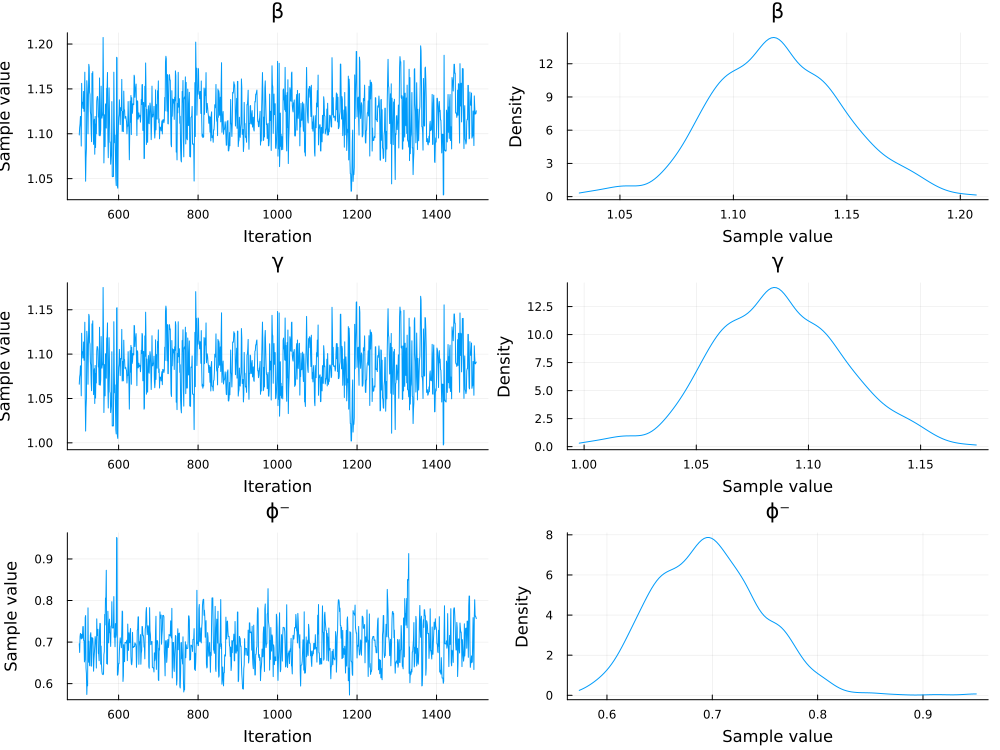

In [10]:
plot(chain_sir)

In [11]:
using DataFrames, Dates, Plots, CSV, DataFramesMeta, MLJ, StatsPlots, LaTeXStrings, DifferentialEquations
using Turing
using LazyArrays
using Random: seed!

In [ ]:
function data_processing(country::String)
    data = CSV.read("../data/confirmed_cases_global.csv", DataFrame)
    rename!(data, 1 => "province", 2 => "country")
    countries = collect(data[:, 2])
    row = findfirst(countries .== country)
    data_row = data[row, :]
    country_data = [i for i in values(data_row[5:end])]
    
    date_strings =String.(names(data))[5:end]
    format = Dates.DateFormat("m/d/Y")
    dates = parse.(Date, date_strings, format) + Year(2000)

    df = DataFrame(confirmed = country_data, dates = dates)    
    return df
end

In [ ]:
start_date = Date(2020,03,01);
end_date = Date(2020,12,01);

In [ ]:
ng_data = data_processing("Nigeria");

# ng_filtered = @subset(ng_data, :confirmed .> 0)

In [ ]:
# range_data = ng_filtered[2,start_date:end_date]

ng = filter(row -> start_date <= row.dates <= end_date, ng_data)

In [ ]:
@df ng plot(:dates,
    :confirmed,
    xlab=L"time", ylab="infected daily",
    yformatter=y -> string(round(Int64, y ÷ 1_000)) * "K",
    label=false)

In [ ]:
# function seir_ode!(du, u, p, t)
#     (S, E, I, R) = u
#     (β, γ) = p
#     N = S + I + R
#     infection = β * I * S / N
#     exposed = γ * E
#     recovery = γ * I
#     @inbounds begin
#         du[1] = -infection # Susceptible
#         du[2] = infection - exposed # Exposed
#         du[2] = exposed - recovery # Infected
#         du[3] = recovery # Recovered
#     end
#     nothing
# end;

using DifferentialEquations

function sir_ode!(du, u, p, t)
    (S, I, R) = u
    (β, γ) = p
    N = S + I + R
    infection = β * I * S / N
    recovery = γ * I
    @inbounds begin
        du[1] = -infection # Susceptible
        du[2] = infection - recovery # Infected
        du[3] = recovery # Recovered
    end
    nothing
end;

In [ ]:
# i₀ = first(ng[:, :confirmed])
# N = last(ng[:, :confirmed])
# e₀ = 100

# u = [N - e₀ - i₀, e₀, i₀, 0.0]
# p = [0.5, 0.1]
# prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
# sol_ode = solve(prob)
# plot(sol_ode, label=[L"S" L"E" L"I" L"R"],
#     lw=4,
#     xlabel=L"t",
#     ylabel=L"N",
#     yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
#     title="SEIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

i₀ = first(ng[:, :confirmed])
N = 2000000

u = [N - i₀, i₀, 0.0]
p = [0.5, 0.05]
prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
sol_ode = solve(prob)
plot(sol_ode, label=[L"S" L"I" L"R"],
    lw=3,
    xlabel=L"t",
    ylabel=L"N",
    yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
    title="SIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

In [ ]:
function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

In [ ]:
seed!(123)

@model function bayes_sir(infected, i₀, r₀, N)
    #calculate number of timepoints
    l = length(infected)

    #priors
    β ~ TruncatedNormal(2, 1, 1e-4, 10)     # using 10 because numerical issues arose
    γ ~ TruncatedNormal(0.4, 0.5, 1e-4, 10) # using 10 because numerical issues arose
    ϕ⁻ ~ truncated(Exponential(5); lower=0, upper=1e5)
    ϕ = 1.0 / ϕ⁻

    #ODE Stuff
    I = i₀
    u0 = [N - I, I, r₀] # S,I,R
    p = [β, γ]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_ode!,
        u0,
        tspan,
        p)
    sol = solve(prob,
        Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
        saveat=1.0)
    solᵢ = Array(sol)[2, :] # New Infected
    solᵢ = max.(1e-4, solᵢ) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(solᵢ, ϕ)))
end;

In [ ]:
infected = ng[:, :confirmed]
r₀ = 1
model_sir = bayes_sir(infected, i₀, r₀, N)
chain_sir = sample(model_sir, NUTS(), 1_000)
summarystats(chain_sir[[:β, :γ]])

In [ ]:
plot(chain_sir)